<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize


%matplotlib inline

In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [3]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()

images not found, donwloading...



extracting...



done



attributes not found, downloading...



done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [4]:
from sklearn.model_selection import train_test_split
data_train, data_val, att_train, att_val = train_test_split(data, attrs, train_size=0.9, shuffle=False)
train_loader = torch.utils.data.DataLoader(data_train, batch_size=128)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=128)

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 128 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [5]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*64*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256)
        )

        self.decoder = nn.Sequential(
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64*64*3),
            nn.ReLU(),
            nn.Unflatten(1, (3, 64, 64))
        )
        # Обратите внимание на формат, в котором функция fetch() возвращает data

    def forward(self, x):

        # <реализуйте forward проход автоэнкодера
        # в качестве возвращаемых переменных -- латентное представление картинки (latent_code)
        # и полученная реконструкция изображения (reconstruction)>
        latent_code = self.encoder(x.float())
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code

In [6]:
import gc
gc.collect()
torch.cuda.empty_cache()

criterion = nn.CrossEntropyLoss()
device = torch.device('cuda:0')
autoencoder = Autoencoder().to(device)
minloss = 1e3
# checkpoint = torch.load("./model (2).pt")
# autoencoder.load_state_dict(checkpoint)
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=3e-4)
criterion = torch.nn.functional.mse_loss
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=3e-4)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [7]:
n_epochs = 200
for epoch in range(n_epochs):
  val_loss = 0
  autoencoder.train()
  for batch in train_loader:
    optimizer.zero_grad()
    batch = batch.swapaxes(1, 3).to(device)
    reconstruction, latent_code = autoencoder(batch)
    loss = criterion(reconstruction.float(), batch.float())
    loss.backward()
    optimizer.step()
  autoencoder.eval()
  with torch.no_grad():
    for batch in val_loader:
      batch = batch.swapaxes(1, 3).to(device)
      reconstruction, latent_code = autoencoder(batch)
      epoch_loss = criterion(reconstruction, batch) / batch.shape[0]
      # if epoch % 5 == 0 and epoch_loss < minloss:
      #   minloss = epoch_loss
      #   torch.save(autoencoder.state_dict(), "model.pt")
      val_loss += epoch_loss

  if epoch % 10 == 0:
    print('%d / %d - loss: %f' % (epoch+1, n_epochs, val_loss))
torch.save(autoencoder.state_dict(), "model.pt")

1 / 200 - loss: 0.005871



11 / 200 - loss: 0.000902



21 / 200 - loss: 0.000707



31 / 200 - loss: 0.000564



41 / 200 - loss: 0.000593



51 / 200 - loss: 0.000448



61 / 200 - loss: 0.000427



71 / 200 - loss: 0.000391



81 / 200 - loss: 0.000378



91 / 200 - loss: 0.000360



101 / 200 - loss: 0.000467



111 / 200 - loss: 0.000380



121 / 200 - loss: 0.000375



131 / 200 - loss: 0.000375



141 / 200 - loss: 0.000369



151 / 200 - loss: 0.000408



161 / 200 - loss: 0.000395



171 / 200 - loss: 0.000394



181 / 200 - loss: 0.000395



191 / 200 - loss: 0.000389


Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

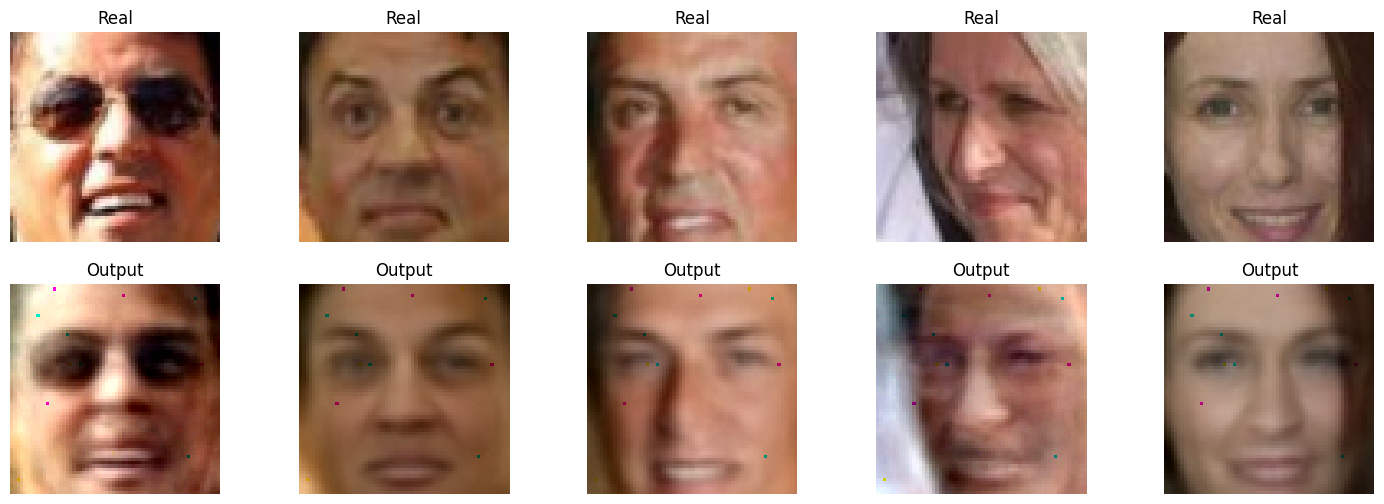

In [8]:
plt.figure(figsize=(18, 6))
batch = next(iter(val_loader))
autoencoder.eval()
rec, _ = autoencoder(batch.swapaxes(1, 3).to(device))
for k in range(5):
    plt.subplot(2, 5, k+1)
    plt.imshow(batch[k])
    plt.title('Real')
    plt.axis('off')

    plt.subplot(2, 5, k+6)
    plt.imshow(rec.detach().swapaxes(1, 3).cpu()[k])
    plt.title('Output')
    plt.axis('off')

plt.show()

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [9]:
example_loader = torch.utils.data.DataLoader(data_val, batch_size=data_val.shape[0])

In [10]:
batch = next(iter(example_loader))
_, latent = autoencoder(batch.swapaxes(1,3).to(device))
latent = latent.detach().cpu()

In [ ]:
print(latent.T.cov().shape)
print(latent.mean(0).shape)

torch.Size([256, 256])



torch.Size([256])


<ipython-input-11-46396f355422>:2: RuntimeWarning: covariance is not symmetric positive-semidefinite.



  z = np.random.multivariate_normal(latent.mean(0), latent.T.cov(), 256)





























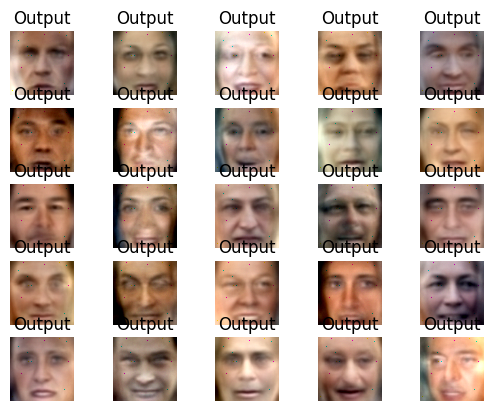

In [11]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.multivariate_normal(latent.mean(0), latent.T.cov(), 256)
output = autoencoder.decoder(torch.from_numpy(z).to(device).float())
for k in range(25):
  plt.subplot(5, 5, k+1)
  plt.imshow(output.swapaxes(1,3).detach().cpu()[k])
  plt.title('Output')
  plt.axis('off')

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [19]:
not_smile = [0, 2, 10, 12, 13, 15, 16, 19, 21, 22, 24, 25, 27, 41, 49, 75, 77, 78, 79, 90, 91, 92]
smile = [1, 3, 4, 5, 8, 9, 11, 14, 18, 26, 31, 33, 34, 58, 60, 68]
autoencoder.eval()
batch = next(iter(train_loader))
_, sad_latent = autoencoder(batch[not_smile].swapaxes(1,3).to(device))
_, smile_latent = autoencoder(batch[smile].swapaxes(1,3).to(device))
print(smile_latent.shape, sad_latent.shape)

torch.Size([16, 256]) torch.Size([22, 256])


(-0.5, 63.5, 63.5, -0.5)

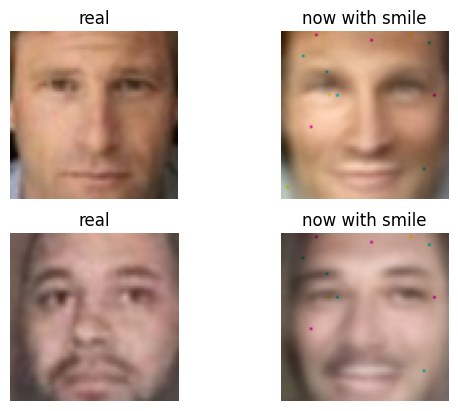

In [32]:
sad_face = sad_latent[[0, 1]]
new_with_smile = autoencoder.decoder(smile_latent.mean(0) - sad_latent.mean(0) + sad_face)
plt.subplot(2, 2, 1)
plt.imshow(batch[not_smile[0]])
plt.title('real')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(new_with_smile[0].swapaxes(0, 2).detach().cpu())
plt.title('now with smile')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(batch[not_smile[1]])
plt.title('real')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(new_with_smile[1].swapaxes(0, 2).detach().cpu())
plt.title('now with smile')
plt.axis('off')

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [2]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4067365.90it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 466448.31it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4371767.52it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2441749.39it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [27]:
features = 64
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(4, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16*28*28, 256),
            nn.ReLU(),
            nn.Linear(256, features*2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(features, 256),
            nn.ReLU(),
            nn.Linear(256, 16*28*28),
            nn.ReLU(),
            nn.Unflatten(1, (16, 28, 28)),
            nn.Conv2d(16, 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(4, 1, kernel_size=3, padding=1)
        )
    def encode(self, x):
        latent = self.encoder(x.float())
        latent = latent.view(-1, 2, features)
        mu = latent[:, 0, :]
        logsigma = latent[:, 1, :]
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.rand_like(std)
            sample = mu + (eps*std)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        reconstruction = self.decoder(z)
        reconstruction = torch.sigmoid(reconstruction)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        sample = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(sample)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [24]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * (1 + 2*logsigma - mu**2 - torch.exp(2 * logsigma)).sum()
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    loss = loss(reconstruction, x)
    return loss

def loss_vae(x, mu, logsigma, reconstruction):
#     print(KL_divergence(mu, logsigma), log_likelihood(x, reconstruction))
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [28]:
criterion = loss_vae
device = torch.device('cuda')
autoencoder = VAE().to(device)

optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=3e-4)

In [40]:
from tqdm.notebook import tqdm
def train(model, optim, loss_fn, train_loader, val_loader, n_epochs):
    min_loss = 1e8
    for epoch in tqdm(range(n_epochs)):
        train_loss = 0
        val_loss = 0
        model.train()
        for (batch, target) in train_loader:
            optim.zero_grad()
            batch = batch.to(device)
            mu, logsigma, reconstruction = model(batch)
            loss = loss_fn(batch, mu, logsigma, reconstruction)
            loss.backward()
            optim.step()
            train_loss += loss / batch.shape[0]
        model.eval()
        with torch.no_grad():
            for batch, target in val_loader:
                batch = batch.to(device)
                mu, logsigma, reconstruction = model(batch)
                loss = loss_fn(batch, mu, logsigma, reconstruction)
                val_loss += loss / batch.shape[0]
            batch, target = next(iter(val_loader))
            _, _, rec = model(batch.to(device).float())
            for i in range(5):
                plt.subplot(2, 5, i+1)
                plt.imshow(batch.swapaxes(1,3).swapaxes(1,2)[i])
                plt.axis('off')
                
                plt.subplot(2, 5, i+6)
                plt.imshow(rec.swapaxes(1,3).swapaxes(1,2).detach().cpu()[i])
                plt.axis('off')
            plt.show()
#         print(val_loss)
        print('%d / %d -- val loss = %f' % (epoch, n_epochs, val_loss))

In [32]:
batch, _ = next(iter(test_loader))
batch = batch.to(device)
mu, logsigma, reconstruction = autoencoder(batch)
# criterion(batch, mu, logsigma, reconstruction)

In [ ]:
train(autoencoder, optimizer, criterion, train_loader, test_loader, 100)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

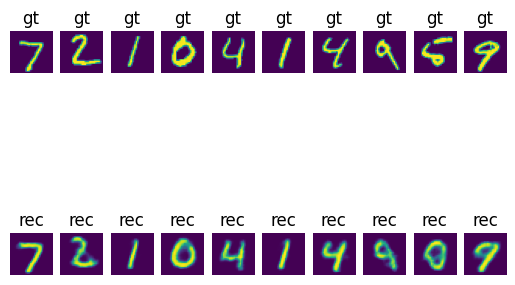

In [10]:
autoencoder.eval()
batch, target = next(iter(test_loader))
mu, logsigma, reconstruction = autoencoder(batch.to(device))
for i in range(10):
    plt.subplot(2, 10,i +1)
    plt.imshow(batch.swapaxes(1, 3).swapaxes(1,2)[i])
    plt.title('gt')
    plt.axis('off')
    
    plt.subplot(2, 10, i+11)
    plt.imshow(reconstruction.swapaxes(1,3).swapaxes(1, 2)[i].detach().cpu())
    plt.title('rec')
    plt.axis('off')

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

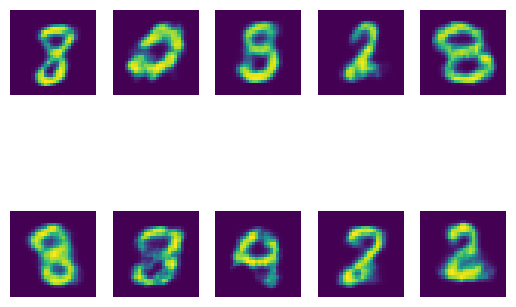

In [14]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = torch.from_numpy(np.array([np.random.normal(0, 1, 64) for i in range(64)])).to(device).float()
output = autoencoder.decode(z)
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(output.swapaxes(1, 3).swapaxes(1,2)[i].detach().cpu())
    plt.axis('off')

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

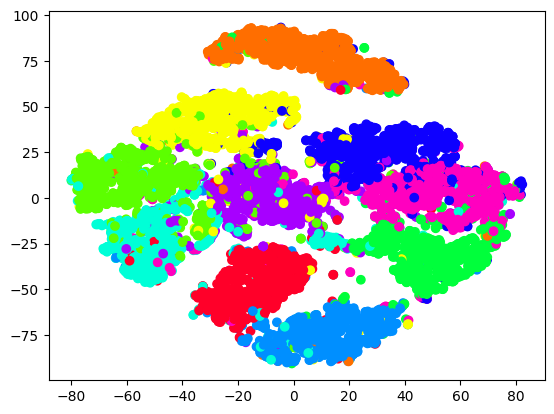

In [23]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>
from sklearn.manifold import TSNE
batch, target = next(iter(torch.utils.data.DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)))
mu, _ = autoencoder.encode(batch.to(device))
mu = TSNE().fit_transform(mu.detach().cpu())
plt.scatter(mu[:, 0], mu[:, 1], c = target, cmap='gist_rainbow')

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
features = 128
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, padding=1),
#             nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
#             nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, features*2)
        )
        
        self.embed_class = nn.Sequential(
            nn.Linear(10, 28*28),
            nn.Unflatten(1, (1, 28, 28)),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(features + 10, 512),
#             nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
#             nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128*28*28),
#             nn.BatchNorm1d(128*28*28),
            nn.ReLU(),
            nn.Unflatten(1, (128, 28, 28)),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 16, kernel_size=3, padding=1),
#             nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, padding=1)
        )
        
#         <определите архитектуры encoder и decoder
#         помните, у encoder должны быть два "хвоста",
#         т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

    def encode(self, x, class_num):
        one_hot = F.one_hot(class_num, num_classes=10)
        one_hot = one_hot.float().to(device)
        embeded_class = self.embed_class(one_hot)
        latent = self.encoder(torch.cat((x, embeded_class), 1))
        latent = latent.view(-1, 2, features)
        mu = latent[:, 0, :]
        logsigma = latent[:, 1, :]
#         <реализуйте forward проход энкодера
#         в качестве ваозвращаемых переменных -- mu, logsigma и класс картинки>

        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.rand_like(std)
            latent = mu + std * eps
            return latent
#             <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, class_num):
#         <реализуйте forward проход декодера
#         в качестве возвращаемой переменной -- reconstruction>
        one_hot = F.one_hot(class_num, num_classes=10)
        one_hot = one_hot.float().to(device)
        latent = torch.cat((z, one_hot), 1)
        reconstruction = self.decoder(latent)
        return reconstruction

    def forward(self, x, class_num):
#         <используя encode и decode, реализуйте forward проход автоэнкодера
#         в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma, class_num = self.encode(x.float(), class_num)
        sample = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(sample, class_num)
        reconstruction = torch.sigmoid(reconstruction)
        return mu, logsigma, reconstruction

  0%|          | 0/75 [00:00<?, ?it/s]

0 / 75 val loss -- 6657.319824


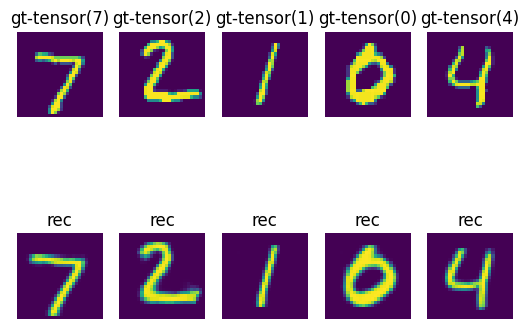

1 / 75 val loss -- 6621.428711

2 / 75 val loss -- 6696.255371

3 / 75 val loss -- 6642.145508

4 / 75 val loss -- 6558.188965

5 / 75 val loss -- 6531.868164


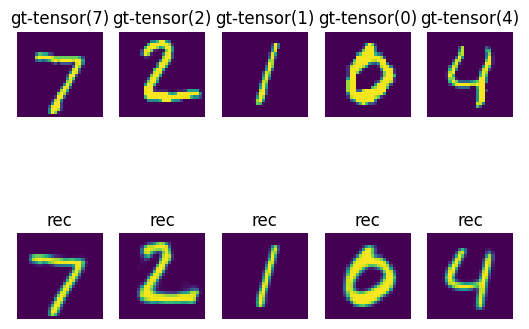

6 / 75 val loss -- 6553.665039

7 / 75 val loss -- 6718.035645

8 / 75 val loss -- 6555.534668

9 / 75 val loss -- 6534.644043

10 / 75 val loss -- 6596.258301


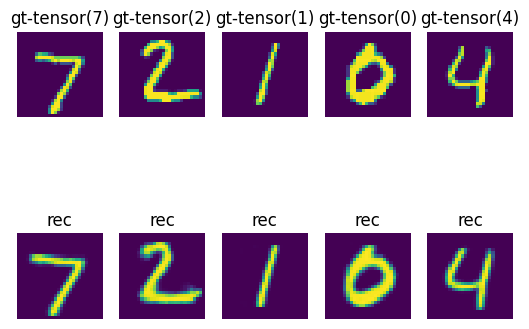

11 / 75 val loss -- 6588.619629

12 / 75 val loss -- 6516.963379

13 / 75 val loss -- 6443.862793

14 / 75 val loss -- 6516.558105

15 / 75 val loss -- 6477.492676


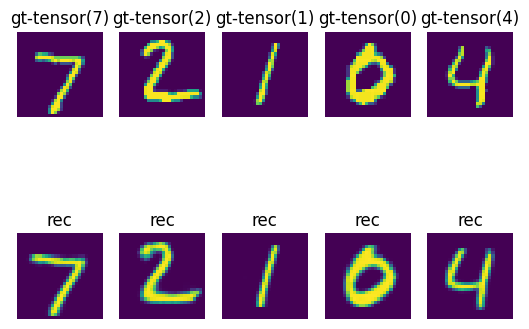

16 / 75 val loss -- 6476.212891

17 / 75 val loss -- 6676.792480

18 / 75 val loss -- 6555.613281

19 / 75 val loss -- 6518.520508

20 / 75 val loss -- 6706.530273


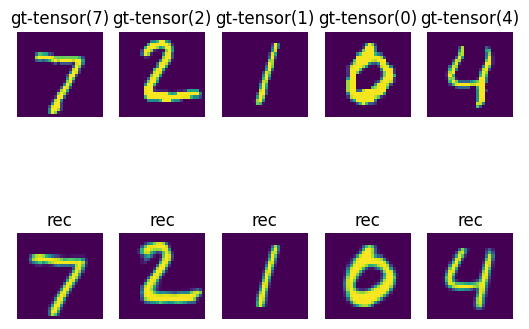

21 / 75 val loss -- 6488.683594

22 / 75 val loss -- 6570.100098

23 / 75 val loss -- 6542.754395

24 / 75 val loss -- 6475.442383

25 / 75 val loss -- 6534.607422


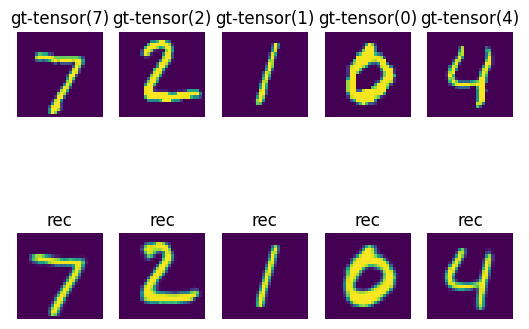

26 / 75 val loss -- 6438.312988

27 / 75 val loss -- 6588.852539

28 / 75 val loss -- 6579.865723

29 / 75 val loss -- 6505.234375

30 / 75 val loss -- 6573.677246


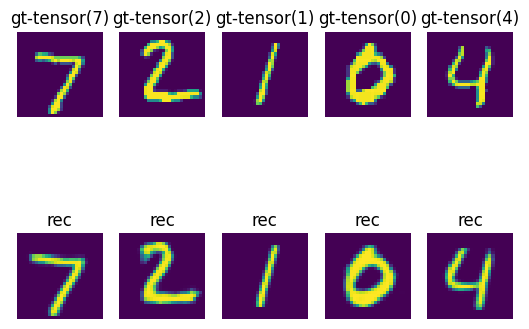

31 / 75 val loss -- 6502.731934

32 / 75 val loss -- 6657.380859

33 / 75 val loss -- 6639.792480

34 / 75 val loss -- 6567.573242

35 / 75 val loss -- 6516.140137


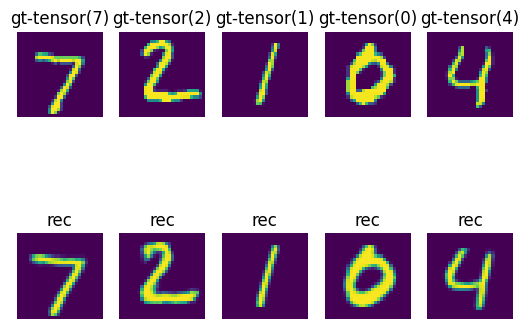

36 / 75 val loss -- 6494.935059

37 / 75 val loss -- 6615.994629

38 / 75 val loss -- 6571.191406

39 / 75 val loss -- 6497.992676

40 / 75 val loss -- 6431.451172


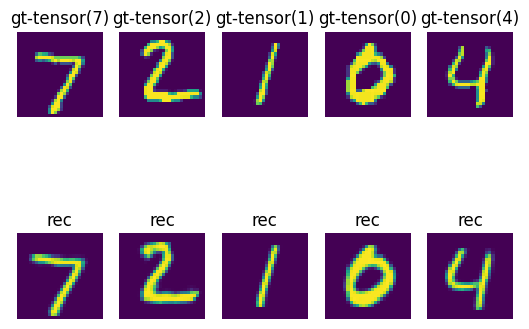

41 / 75 val loss -- 6552.765137

42 / 75 val loss -- 6518.764160

43 / 75 val loss -- 6581.608398

44 / 75 val loss -- 6435.008789

45 / 75 val loss -- 6566.938965


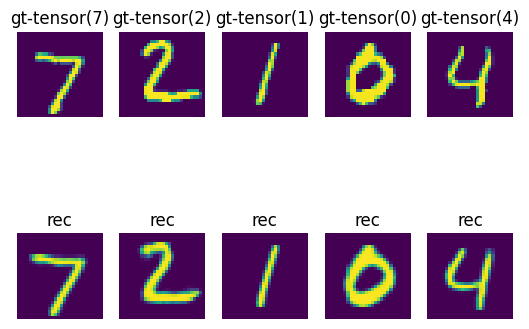

46 / 75 val loss -- 6522.390137

47 / 75 val loss -- 6547.768555

48 / 75 val loss -- 6504.206543

49 / 75 val loss -- 6495.624512

50 / 75 val loss -- 6574.226562


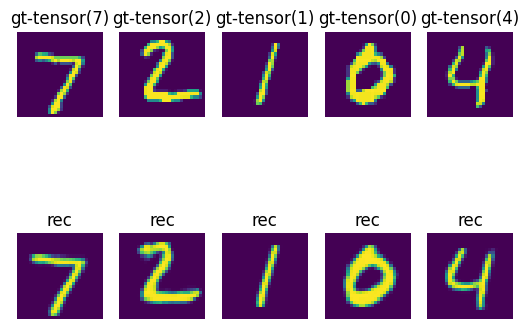

51 / 75 val loss -- 6518.352539

52 / 75 val loss -- 6621.170898

53 / 75 val loss -- 6622.815918

54 / 75 val loss -- 6498.470703

55 / 75 val loss -- 6543.777832


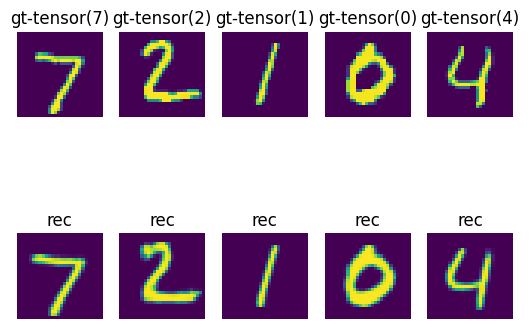

56 / 75 val loss -- 6666.606934

57 / 75 val loss -- 6576.879395

58 / 75 val loss -- 6573.694336

59 / 75 val loss -- 6567.983887

60 / 75 val loss -- 6601.914551


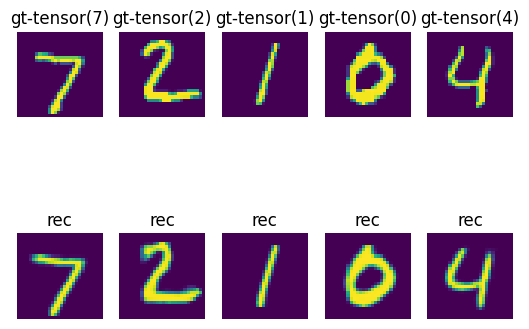

61 / 75 val loss -- 6731.425293

62 / 75 val loss -- 6599.996582

63 / 75 val loss -- 6561.746094

64 / 75 val loss -- 6605.397461

65 / 75 val loss -- 6656.255371


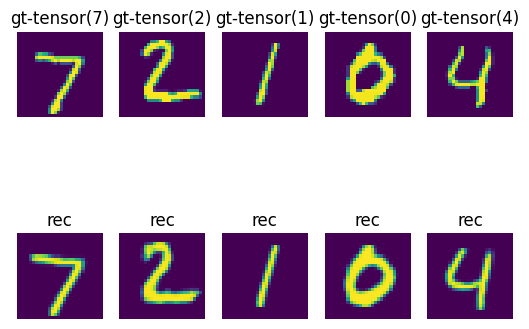

66 / 75 val loss -- 6753.796387

67 / 75 val loss -- 6609.418945

68 / 75 val loss -- 6667.463379

69 / 75 val loss -- 6590.848633

70 / 75 val loss -- 6628.629395


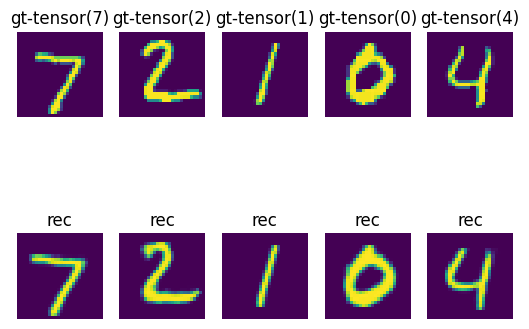

71 / 75 val loss -- 6678.544922

72 / 75 val loss -- 6643.110352

73 / 75 val loss -- 6714.315918

74 / 75 val loss -- 6752.226562


In [ ]:
train(autoencoder2, optim, loss_fn, 75, train_loader, test_loader)

tensor([[ 0.1910,  0.1216, -0.1236,  ..., -0.2098,  0.1099, -0.1446],

        [ 0.2232, -0.1154,  0.4555,  ..., -0.4689,  0.1888, -0.0400],

        [ 0.0637,  0.1600,  0.0176,  ...,  0.0727,  0.0445,  0.1072],

        ...,

        [-0.4779,  0.2848,  0.5366,  ...,  0.1435,  0.1069, -0.2365],

        [-0.3662,  0.4048, -0.3836,  ...,  0.0800, -0.0530,  0.1436],

        [-0.1258,  0.1334,  0.2275,  ...,  0.1235,  0.0831,  0.3794]])

tensor([[ 0.0195, -0.0077, -0.0275,  ..., -0.0400,  0.0122, -0.0270],

        [ 0.0133, -0.0518,  0.0458,  ..., -0.0818,  0.0221, -0.0226],

        [ 0.0105,  0.0096, -0.0107,  ...,  0.0037,  0.0045,  0.0105],

        ...,

        [-0.0699,  0.0065,  0.0477,  ..., -0.0007,  0.0124, -0.0542],

        [-0.0600,  0.0181, -0.0664,  ..., -0.0139, -0.0137,  0.0021],

        [-0.0228, -0.0115,  0.0085,  ..., -0.0010,  0.0062,  0.0337]])


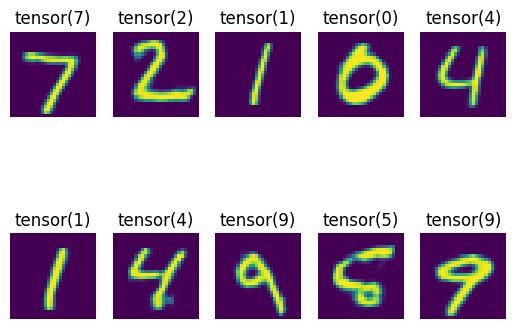

In [ ]:
autoencoder2.eval()
batch, label = next(iter(test_loader))
_, _, rec = autoencoder2(batch.to(device), label)
mus, logsigma, class_num = autoencoder2.encode(batch.to(device), label)
print(mus.detach().cpu())
print(logsigma.detach().cpu())
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(rec.swapaxes(1, 3).swapaxes(1, 2)[i].detach().cpu())
    plt.title(str(label[i]))
    plt.axis('off')

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

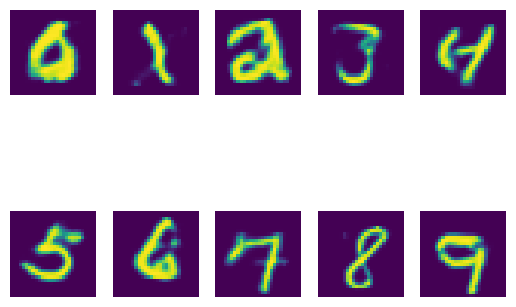

In [ ]:
z = torch.from_numpy(np.array([np.random.normal(mus.detach().cpu().mean(), 1, 128) for i in range(10)])).to(device).float()
output = torch.sigmoid(autoencoder2.decode(z, torch.arange(0, 10)))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(output.swapaxes(1, 3).swapaxes(1,2)[i].detach().cpu())
    plt.axis('off')

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

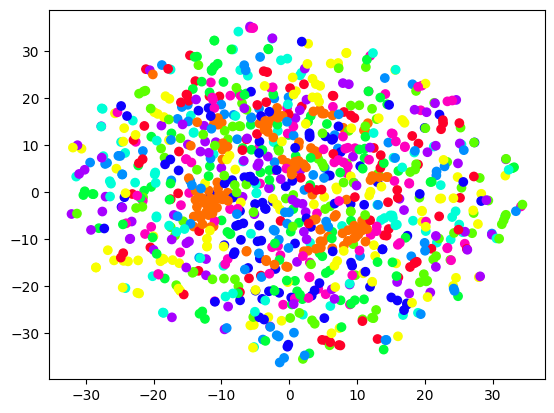

In [ ]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>
from sklearn.manifold import TSNE
autoencoder2.eval()
batch, target = next(iter(torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1024, shuffle=False)))
mu, _ , _ = autoencoder2.encode(batch.to(device), target)
mu = TSNE().fit_transform(mu.detach().cpu())
plt.scatter(mu[:, 0], mu[:, 1], c = target, cmap='gist_rainbow')

Вероятно что из-за того что мы еще конкатенируем с one_hot вектором получается такой невнятный результат

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

In [3]:
!cp /kaggle/input/lfwpeople/* /kaggle/working/

In [ ]:
!cd /kaggle/working/ && tar xzvf lfw-funneled.tgz && rm lfw-funneled.tgz

In [2]:
def fetch_dataset(    images_name = "/kaggle/working/lfw_funneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists

    #read attrs

    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)


    # print(df.shape)
    #image preprocessing
    photo_ids =photo_ids['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    photo_ids = np.stack(photo_ids.values)#.astype('uint8')

    return photo_ids

In [3]:
data_set = fetch_dataset().swapaxes(1,3).swapaxes(2, 3)

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
data_noisy_set = data_set + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data_set.shape)

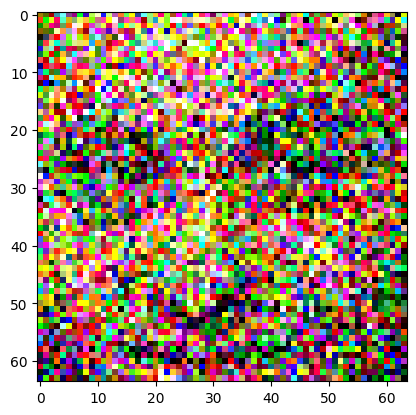

In [66]:
plt.imshow(data_noisy_set.swapaxes(1, 3).swapaxes(1, 2)[1])

In [4]:
from sklearn.model_selection import train_test_split
batch_size = 64
data_train, data_test = train_test_split(data_set, train_size=0.9, shuffle=False)
train_loader = torch.utils.data.DataLoader(data_train, batch_size)
val_loader = torch.utils.data.DataLoader(data_test, batch_size)

In [68]:
batch_size = 64
data_noisy_train, data_noisy_test = train_test_split(data_noisy_set, train_size=0.9, shuffle=False)
train_noisy_loader = torch.utils.data.DataLoader(data_noisy_train, batch_size)
val_noisy_loader = torch.utils.data.DataLoader(data_noisy_test, batch_size)

In [5]:
import gc
del data_set, data_train, data_test
gc.collect()
torch.cuda.empty_cache()

In [10]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*64*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256)
        )

        self.decoder = nn.Sequential(
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64*64*3),
            nn.ReLU(),
            nn.Unflatten(1, (3, 64, 64))
        )
        # Обратите внимание на формат, в котором функция fetch() возвращает data

    def forward(self, x):

        # <реализуйте forward проход автоэнкодера
        # в качестве возвращаемых переменных -- латентное представление картинки (latent_code)
        # и полученная реконструкция изображения (reconstruction)>
        latent_code = self.encoder(x.float())
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code

In [9]:
from tqdm.notebook import tqdm
def train(model, optim, loss_fn, train_loader, val_loader, train_noisy, val_noisy, n_epochs):
#     train_hist, val_hist = [], []
#     min_loss = 1e8
    for epoch in tqdm(range(n_epochs)):
        train_loss, val_loss = 0, 0
        model.train()
        for noisy, real in zip(train_noisy, train_loader):
            optim.zero_grad()
            noisy, real = noisy.to(device).float(), real.to(device).float()
#             noisy, real = noisy.swapaxes(1, 3), real.swapaxes(1, 3)
            output,_ = model(noisy)
            loss = loss_fn(output, real)
            loss.backward()
            optim.step()
            train_loss += loss / noisy.shape[0]
#         train_hist.append(train_loss)
        model.eval()
        with torch.no_grad():
            for noisy, real in zip(val_noisy, val_loader):
                noisy, real = noisy.to(device).float(), real.to(device).float()
#                 noisy, real = noisy.swapaxes(1, 3), real.swapaxes(1, 3)
                output, _ = model(noisy)
                loss = loss_fn(output, real)
                val_loss += loss / noisy.shape[0]
#             val_hist.append(val_loss)
            if epoch% 5 == 0:
#                 if val_loss < min_loss:
# #                     torch.save(model.state_dict(), 'denoise.pt')
#                     min_loss = val_loss
#                 noisy, real = next(iter(zip(val_noisy, val_loader)))
#                 noisy, real = noisy.to(device).float(), real.to(device).float()
#                 output, _ = model(noisy)
#                 plt.subplot(1, 2, 1)
#                 plt.imshow(noisy)
                print("%d / %d -- val loss %f, train loss %f" % (epoch, n_epochs, val_loss, train_loss))
#         gc.collect()
#         torch.cuda.empty_cache()

In [11]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [52]:
device = 'cuda'
loss_fn = F.mse_loss
autoencoder = Autoencoder().to(device)
optim = torch.optim.Adam(autoencoder.parameters(), lr=3e-4)

NameError: name 'Autoencoder' is not defined

In [59]:
train(autoencoder, optim, loss_fn, train_loader, val_loader, train_noisy_loader, val_noisy_loader, 200)

  0%|          | 0/200 [00:00<?, ?it/s]

0 / 200 -- val loss 0.010771, train loss 0.140605
5 / 200 -- val loss 0.005441, train loss 0.041190
10 / 200 -- val loss 0.003547, train loss 0.028065
15 / 200 -- val loss 0.003264, train loss 0.022215
20 / 200 -- val loss 0.003180, train loss 0.018545
25 / 200 -- val loss 0.002574, train loss 0.017450
30 / 200 -- val loss 0.002316, train loss 0.016717
35 / 200 -- val loss 0.002417, train loss 0.014920
40 / 200 -- val loss 0.002568, train loss 0.015390
45 / 200 -- val loss 0.002350, train loss 0.015365
50 / 200 -- val loss 0.002391, train loss 0.013347
55 / 200 -- val loss 0.002370, train loss 0.013643
60 / 200 -- val loss 0.002501, train loss 0.015406
65 / 200 -- val loss 0.002420, train loss 0.013398
70 / 200 -- val loss 0.002374, train loss 0.012674
75 / 200 -- val loss 0.002549, train loss 0.012372
80 / 200 -- val loss 0.002470, train loss 0.013973
85 / 200 -- val loss 0.002437, train loss 0.012918
90 / 200 -- val loss 0.002403, train loss 0.012011
95 / 200 -- val loss 0.002293, tr

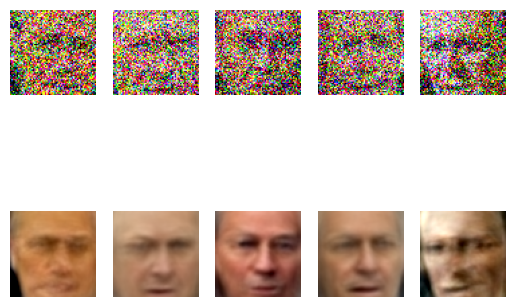

In [73]:
noisy, real = next(iter(zip(val_noisy_loader, val_loader)))
noisy, real = noisy.to(device).float(), real.to(device).float()
out,_ = autoencoder(noisy)
for i in range(5):
    plt.subplot(2, 5, i+6)
    plt.imshow(out.detach().cpu().swapaxes(1,3).swapaxes(1, 2)[i])
    plt.axis('off')
    
    plt.subplot(2, 5, i+1)
    plt.imshow(noisy.detach().cpu().swapaxes(1,3).swapaxes(1, 2)[i])
    plt.axis('off')

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [97]:
features = 512
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),
            nn.Flatten(),
            nn.Linear(8192, 2048),
            nn.ReLU(),
            nn.Dropout1d(p=0.3),
            nn.Linear(2048, features*2),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(features, 1024),
            nn.ReLU(),
            nn.Dropout1d(p=0.3),
            nn.Linear(1024, 5*5*128),
            nn.ReLU(),
            nn.Dropout1d(p=0.3),
            nn.Linear(5*5*128, 8*8*128),
            nn.ReLU(),
            nn.Dropout1d(p=0.3),
            nn.Linear(8*8*128, 16*16*128),
            nn.ReLU(),
            nn.Dropout1d(p=0.3),
            nn.Linear(16*16*128, 32*32*64),
            nn.ReLU()
            nn.Dropout1d(p=0.3),
            nn.Unflatten(1, (64, 32, 32)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(8, 3, kernel_size=3, padding=1)
        )
    def encode(self, x):
        latent = self.encoder(x.float())
        latent = latent.view(-1, 2, features)
        mu = latent[:, 0, :]
        logsigma = latent[:, 1, :]
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.rand_like(std)
            sample = mu + (eps*std)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        reconstruction = self.decoder(z)
        reconstruction = torch.sigmoid(reconstruction)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        sample = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(sample)
        return mu, logsigma, reconstruction

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2600720082.py, line 36)

In [21]:
from tqdm.notebook import tqdm
def train(model, optim, loss_fn, train_loader, val_loader, n_epochs, device):
    min_loss = 1e9
    latent = []
    for epoch in tqdm(range(n_epochs)):
        train_loss, val_loss = 0, 0
        model.train()
        for batch in train_loader:
            batch = batch.to(device).float()
            mu, logsigma, reconstruction = model(batch)
            loss = loss_fn(batch, mu, logsigma, reconstruction)
            batch = batch.detach().cpu()
            loss.backward()
            optim.step()
            train_loss += loss/batch.shape[0]
            if len(latent) == 0:
                latent = model.module.gaussian_sampler(mu, logsigma)
            else:
                latent = torch.cat((latent, model.module.gaussian_sampler(mu, logsigma)), 0)
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device).float()
                mu, logsigma, reconstruction = model(batch)
                loss = loss_fn(batch, mu, logsigma, reconstruction)
                val_loss += loss/batch.shape[0]
            if (epoch+1) % 5 == 0 or epoch == 0:
                batch = next(iter(val_loader))
                batch = batch.to(device).float()
                _, _, reconstruction = model(batch)
                for i in range(5):
                    plt.subplot(2, 5, i+1)
                    plt.imshow(batch.swapaxes(1,3).swapaxes(1, 2)[i].detach().cpu())
                    plt.axis('off')
                    
                    plt.subplot(2, 5, i+6)
                    plt.imshow(reconstruction.swapaxes(1,3).swapaxes(1, 2)[i].detach().cpu())
                    plt.axis('off')
                plt.show()
            if (epoch+1)%30 == 0 and val_loss < min_loss:
                torch.save(model.state_dict(), 'VAE.pt')
                min_loss= val_loss
        print("%d / %d -- val loss %f, train loss %f" % (epoch, n_epochs, val_loss, train_loss))
    return latent

In [93]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * (1 + 2*logsigma - mu**2 - torch.exp(2*logsigma)).sum()
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = F.mse_loss
    loss = loss(reconstruction, x)
    return loss

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [24]:
!sudo kill -9 PID

kill: failed to parse argument: 'PID'


In [98]:
import gc
torch.cuda.empty_cache()
gc.collect()

22026

In [99]:
device = 'cuda:0'
autoencoder = VAE().to(device)
autoencoder = torch.nn.DataParallel(autoencoder)
optim = torch.optim.AdamW(autoencoder.parameters(), lr=3e-4)
loss_fn = loss_vae

In [ ]:
codes = train(autoencoder, optim, loss_vae, train_loader, val_loader, 50, device)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>